In [1]:
import numpy as np
import tensorflow as tf
import FeatureVis
import utils
import matplotlib.pyplot as plt 
%matplotlib inline

# Dataset 

Load 'MNIST' dataset and preprocess data

In [2]:
#hyperparameter
BATCH_SIZE = 32
REPEAT = 1000
MAX_STEP = 2000
lr = 1e-4

In [3]:
#call dataset
mnist = tf.keras.datasets.mnist
#load dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()
#normalize dataset and cast to float32
x_train, x_test = x_train.astype('float32') / 255.0, x_test.astype('float32') / 255.0

#add channel dimension 
x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]

#training set
train_ds = tf.data.Dataset.from_tensor_slices(
    (x_train, y_train)).shuffle(10000).repeat(REPEAT).batch(BATCH_SIZE )

#test set 
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(BATCH_SIZE)

# Model 

In [4]:
from tensorflow.keras import Model, Sequential 
from tensorflow.keras.layers import Dense, Flatten, Conv2D, BatchNormalization, UpSampling2D
from tensorflow.keras.layers import Conv2DTranspose, Reshape, ReLU, LeakyReLU, MaxPooling2D, InputLayer, Input

model = Sequential([
    InputLayer((28, 28, 1)),
    Conv2D(16, 5, padding ='same', activation = 'relu', name='layer_conv1'),
    Conv2D(36, 5, padding ='same', activation= 'relu', name='layer_conv2'),
    Flatten(),
    Dense(128, activation = 'relu', name='layer_fc1'),
    Dense(10, activation = 'softmax',name='layer_fc_out'),
])

model.build((None, 28, 28, 1))

## Train Model

In [5]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()
opt = tf.keras.optimizers.Adam(lr)

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')



@tf.function
def train_fn(model, imgs, lbls):
    with tf.GradientTape() as tape:
        logits = model(imgs)
        loss = loss_fn(lbls, logits)
    grad = tape.gradient(loss, model.trainable_variables)
    opt.apply_gradients(zip(grad, model.trainable_variables))
    
    train_loss(loss)
    train_accuracy(lbls, logits)


@tf.function
def test_fn(model, imgs, lbls):
    t_logits = model(imgs)
    t_loss = loss_object(lbls, t_logits)

    test_loss(t_loss)
    test_accuracy(lbls, t_logits)
    
for steps,(imgs, lbls) in enumerate(train_ds):
    if steps> MAX_STEP:
        print("End of Step")
        break
        
    train_fn(model, imgs, lbls)
    template = 'Step: {}, Test Loss: {}, Test Acc: {}'
    if not steps%100:
        print(template.format(steps, train_loss.result(), train_accuracy.result()*100 ))

Step: 0, Test Loss: 2.281848907470703, Test Acc: 12.5
Step: 100, Test Loss: 0.8589367866516113, Test Acc: 75.99009704589844
Step: 200, Test Loss: 0.614784300327301, Test Acc: 82.58706665039062
Step: 300, Test Loss: 0.519914984703064, Test Acc: 85.20556640625
Step: 400, Test Loss: 0.4524301588535309, Test Acc: 87.10255432128906
Step: 500, Test Loss: 0.4115581214427948, Test Acc: 88.24226379394531
Step: 600, Test Loss: 0.37585359811782837, Test Acc: 89.1690902709961
Step: 700, Test Loss: 0.3490813076496124, Test Acc: 89.93402099609375
Step: 800, Test Loss: 0.32644760608673096, Test Acc: 90.57817840576172
Step: 900, Test Loss: 0.3069719970226288, Test Acc: 91.13484954833984
Step: 1000, Test Loss: 0.28956180810928345, Test Acc: 91.60839080810547
Step: 1100, Test Loss: 0.27624690532684326, Test Acc: 92.00443267822266
Step: 1200, Test Loss: 0.2633330821990967, Test Acc: 92.38655853271484
Step: 1300, Test Loss: 0.2524617314338684, Test Acc: 92.7219467163086
Step: 1400, Test Loss: 0.2431143075

# Use Case

Two ways to retrive layer name

## Use get_layer_name() from utils

This function returns a list of layer names 

In [6]:
layer_names = utils.get_layer_name(model)
print(layer_names)

['layer_conv1', 'layer_conv2', 'flatten', 'layer_fc1', 'layer_fc_out']


## Use layers_dict() from Activations class in FeatureVis

This function returns dictionary with key: Layer Names, value: Layer Information 

In [7]:
acti = FeatureVis.Activations()
layers_name = acti.layers_dict(model)
print(layers_name)

{'flatten': <tensorflow.python.keras.layers.core.Flatten object at 0x7facf83b4400>, 'layer_conv1': <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fad18c17400>, 'layer_fc_out': <tensorflow.python.keras.layers.core.Dense object at 0x7facf83b4860>, 'layer_conv2': <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7facf839bf28>, 'layer_fc1': <tensorflow.python.keras.layers.core.Dense object at 0x7facf83b4518>}


# Visualizing weights

## Retrieve weights with layer_get_weights()

In [8]:
l1_name, l1 = utils.layer_get_weights(model, 'conv')

layer_conv1 (5, 5, 1, 16)
layer_conv2 (5, 5, 16, 36)


## Visualize filters with vis_filters() from utils

Layer name: layer_conv1


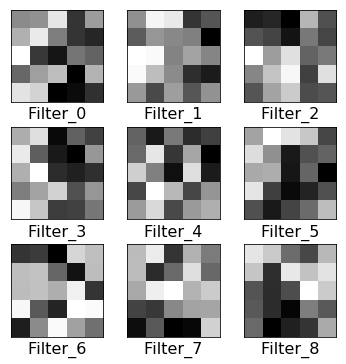

Layer name: layer_conv2


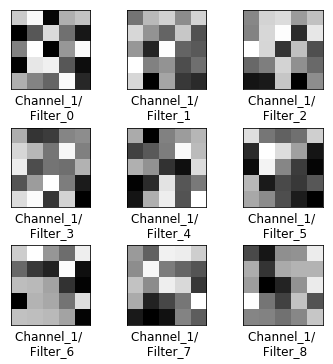

In [10]:
for i in range(len(l1_name)):
    utils.vis_filters(l1_name[i], l1[i], n_filters = 9, n_channel = 2)

# Visualizing Feature Maps 

Use an input image for visualizing feature maps

Original shape: (28, 28, 1)
Expanded dim shape:  (1, 28, 28, 1)


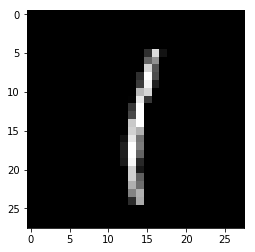

In [13]:
for steps,(imgs,lbls) in enumerate(train_ds):
    img_test = imgs[0]
    break
    
print("Original shape:", img_test.shape)
#convert from 3D to 4D (sample, row_size, col_size, channel)
img_test = tf.expand_dims(img_test, 0) 
print("Expanded dim shape: ", img_test.shape)

plt.imshow(np.squeeze(img_test), cmap = 'gray')
plt.show()

Shape of feature maps: (1, 28, 28, 16)
Number of feature maps in layer:  16


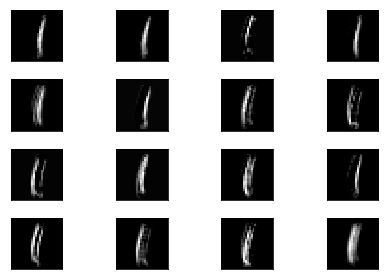

In [15]:
acti = FeatureVis.Activations()
#retrieve feature maps 
feature_maps = acti.feature_maps(model,'layer_conv1', img_test)
#plot feature maps in grid
fm_plot = acti.plot_feature_maps(feature_maps, 4, 4)

# Activation Maximization

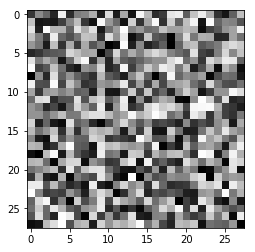

In [16]:
#create random image for activation maximization 
random_image = np.random.random((1, 28, 28, 1))

plt.imshow(np.squeeze(random_image), cmap = 'gray')
plt.show()

In [17]:
acti = FeatureVis.Activations()
#optimize activation
acti_max_img = acti.acti_max(layer_name = 'layer_conv1',inp_img = random_image, 
                             model = model, n_iter = 100, feature_index = 1)

Step: 0, Loss: 0.1453474760055542, Learning rate: 1.7260199785232544

Step: 10, Loss: 2.896674394607544, Learning rate: 1.7260199785232544

Step: 20, Loss: 5.678755760192871, Learning rate: 1.7260199785232544

Step: 30, Loss: 8.465335845947266, Learning rate: 1.7260199785232544

Step: 40, Loss: 11.252511024475098, Learning rate: 1.7260199785232544

Step: 50, Loss: 14.039875030517578, Learning rate: 1.7260199785232544

Step: 60, Loss: 16.827367782592773, Learning rate: 1.7260199785232544

Step: 70, Loss: 19.614683151245117, Learning rate: 1.7260199785232544

Step: 80, Loss: 22.401226043701172, Learning rate: 1.7260199785232544

Step: 90, Loss: 25.18697738647461, Learning rate: 1.7260199785232544



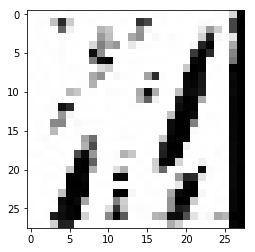

In [18]:
plt.imshow(np.squeeze(acti_max_img), cmap = 'gray')